In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import process
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter('ignore')

In [2]:
# Load dataset for movies and ratings
df_movies = pd.read_csv("movies.csv")
df_ratings = pd.read_csv("ratings.csv")

In [3]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


### Method 1: Colloborative Filtering

Recommends movies based on user preferences.

##### Pivot data for moveid and user id. This will give us information which users gave rating to which movies.

In [7]:
final_dataset = df_ratings.pivot(index='movieId',columns='userId',values='rating')
final_dataset.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,...,4.0,NaN,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,...,NaN,4.0,NaN,5.0,3.5,NaN,NaN,2.0,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN


#### Replace NaN with 0

In [9]:
final_dataset.fillna(0,inplace=True)
final_dataset.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Data is sparse. That means there are lot of 0. So we need to remove the noise.

In [11]:
# lets get the number of votes each movie received
no_user_voted = df_ratings.groupby('movieId')['rating'].agg('count')

# lets get the number of votes each user gave
no_movies_voted = df_ratings.groupby('userId')['rating'].agg('count')

In [12]:
no_user_voted.head()

movieId
1    215
2    110
3     52
4      7
5     49
Name: rating, dtype: int64

In [13]:
no_movies_voted.head()

userId
1    232
2     29
3     39
4    216
5     44
Name: rating, dtype: int64

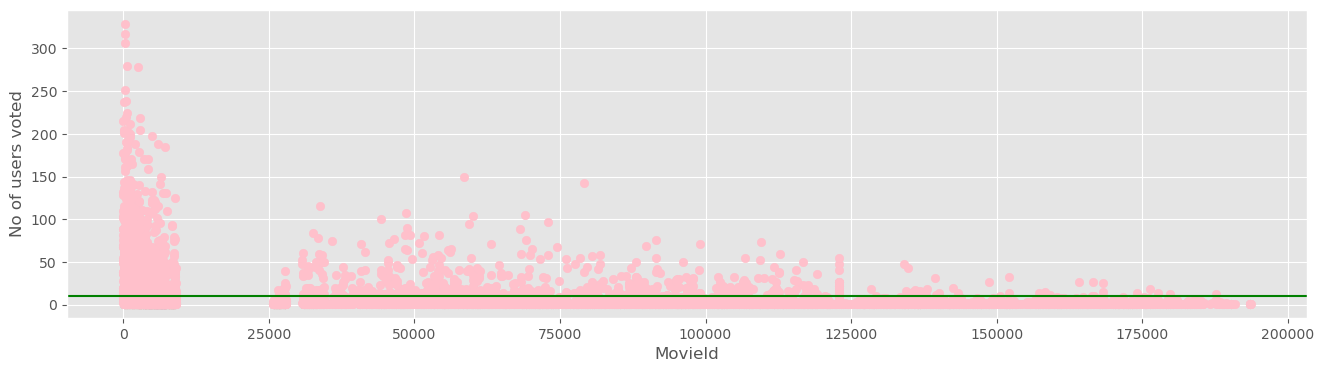

In [14]:
plt.style.use("ggplot")
fig,axes = plt.subplots(1,1, figsize=(16,4))
plt.scatter(no_user_voted.index, no_user_voted, color="pink")
# set threshold of 10. Atleast 10 votes should be provided.
plt.axhline(y=10, color='green') 
plt.xlabel("MovieId")
plt.ylabel("No of users voted")
plt.show()

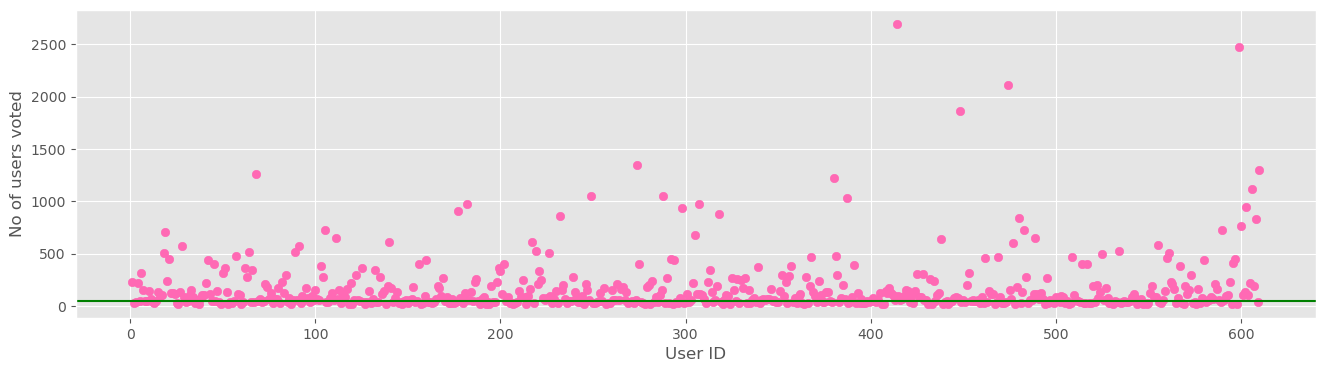

In [15]:
plt.style.use("ggplot")
fig,axes = plt.subplots(1,1, figsize=(16,4))
plt.scatter(no_movies_voted.index, no_movies_voted, color="hotpink")
# set threshold of 50. Atleast 50 votes should be present for movie.
plt.axhline(y=50, color='green')
plt.xlabel("User ID")
plt.ylabel("No of users voted")
plt.show()

#### In our dataset will just keep the data where user has provided more than 50 movies and only movies has recived more than 10 votes

In [17]:
final_dataset = final_dataset.loc[no_user_voted[no_user_voted > 10].index, :]

In [18]:
final_dataset=final_dataset.loc[:,no_movies_voted[no_movies_voted > 50].index]
final_dataset.head()

userId,1,4,6,7,10,11,15,16,17,18,...,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,3.5,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,4.0,...,0.0,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,5.0


In [19]:
sample = np.array([[0,0,3,0,0],[4,0,0,0,2],[0,0,0,0,1]])
sparsity = 1.0 - ( np.count_nonzero(sample) / float(sample.size) )
print(sparsity)

0.7333333333333334


#### The function csr_matrix() is used to create a sparse matrix of compressed sparse row format

In [21]:
csr_sample = csr_matrix(sample)
print(csr_sample)

  (0, 2)	3
  (1, 0)	4
  (1, 4)	2
  (2, 4)	1


In [22]:
csr_movie_data = csr_matrix(final_dataset.values)
final_dataset.reset_index(inplace=True)

In [23]:
csr_movie_data

<2121x378 sparse matrix of type '<class 'numpy.float64'>'
	with 72893 stored elements in Compressed Sparse Row format>

A KNN model is used to find similar movies based on user rating patterns. The similarity between movies is measured using cosine similarity.

In [25]:
# I will use cosine similarity metric. 
# It is a way to measure how similar two vectors are.
# (1 - cosine distance) is cosine similarity.
# I want to each cell in algorithm so I am setting it as brute.

knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20)
knn.fit(csr_movie_data)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=20)

In [26]:
# Create a function for recomendation using knn method
# 1. Find the input movie in the dataset.
# 2. Retrieve its k-nearest neighbors (most similar movies).
# 3. Return a list of recommended movies.

def get_movie_recommendation(movie_name):
    
    n_movies_to_recommend = 10 #setting 10 as count for recommendation.
    
    movie_list = df_movies[df_movies['title'].str.contains(movie_name)]  
    if len(movie_list):        
        movie_idx= movie_list.iloc[0]['movieId']
        movie_idx = final_dataset[final_dataset['movieId'] == movie_idx].index[0]
        distances , indices = knn.kneighbors(csr_movie_data[movie_idx],
                                             n_neighbors=n_movies_to_recommend+1)    
        rec_movie_indices = sorted(list(
            zip(indices.squeeze().tolist(),distances.
                squeeze().tolist())),key=lambda x: x[1])[:0:-1]
        
        recommend_frame = []
        
        for val in rec_movie_indices:
            movie_idx = final_dataset.iloc[val[0]]['movieId']
            idx = df_movies[df_movies['movieId'] == movie_idx].index
            recommend_frame.append({'Title':
                                    df_movies.iloc[idx]['title'].
                                    values[0],'Distance':val[1]})
            
        df = pd.DataFrame(recommend_frame,index=range(1,n_movies_to_recommend+1))
        return df
    else:
        return "No movies found. Please check your input"

In [27]:
# Prompt the user to input a movie name
# movie_name = input("Please enter the movie name: ")
# print(f"You entered: {movie_name}")
movie_name = "Dark Knight"

In [28]:
# Function Call
recommendations = get_movie_recommendation(movie_name)

if isinstance(recommendations, pd.DataFrame):
    display(recommendations)  
else:
    print(recommendations)

,Title,Distance
1,Inglourious Basterds (2009),0.374613
2,Kill Bill: Vol. 1 (2003),0.364388
3,WALL·E (2008),0.364129
4,Avatar (2009),0.358937
5,"Hangover, The (2009)",0.348019
6,"Lord of the Rings: The Return of the King, The...",0.347528
7,"Dark Knight Rises, The (2012)",0.308688
8,Batman Begins (2005),0.306755
9,Iron Man (2008),0.285835
10,Inception (2010),0.213876


In [29]:
# Crate Gradio Web App for easy interaction
              
import gradio as gr

def recommend_movies(movie_name):
    df = get_movie_recommendation(movie_name)
    if isinstance(df, pd.DataFrame):
        return df.to_string(index=False)
    else:
        return df
app = gr.Interface(
    fn = recommend_movies, 
    inputs = "text",
    outputs = "text", 
    title = "Movie Recommendations : Collaborative Filtering",
    description = "Enter a movie name"
)

app.launch()

* Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


##### Collaborative Filtering is a technique that recommends movies based on the preferences of similar users. It provides results based on users who have similar likes in the past.
*************************************************************

### Method 2: Content based filtering

#### Content-based filtering recommends movies that are similar in content (e.g., genre). Instead of looking at user ratings, it compares the attributes of the movies. Content based filtering provides results with highest similarity score.

In [33]:
movies = pd.read_csv("movies.csv")

In [34]:
n_movies = movies['movieId'].nunique()
print(f"There are {n_movies} unique movies in our movies dataset.")

There are 9742 unique movies in our movies dataset.


The genres column contains multiple genres separated by |.

1. Genres were split into a list for each movie.

2. One-hot encoding was applied to convert genres into numerical features.

In [36]:
movies['genres'] = movies['genres'].apply(lambda x: x.split("|"))
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


In [37]:
from collections import Counter

genre_frequency = Counter(g for genres in movies['genres'] for g in genres)

print(f"There are {len(genre_frequency)} genres.")

genre_frequency

There are 20 genres.


Counter({'Drama': 4361,
         'Comedy': 3756,
         'Thriller': 1894,
         'Action': 1828,
         'Romance': 1596,
         'Adventure': 1263,
         'Crime': 1199,
         'Sci-Fi': 980,
         'Horror': 978,
         'Fantasy': 779,
         'Children': 664,
         'Animation': 611,
         'Mystery': 573,
         'Documentary': 440,
         'War': 382,
         'Musical': 334,
         'Western': 167,
         'IMAX': 158,
         'Film-Noir': 87,
         '(no genres listed)': 34})

In [38]:
print("The 5 most common genres: \n", genre_frequency.most_common(5))

The 5 most common genres: 
 [('Drama', 4361), ('Comedy', 3756), ('Thriller', 1894), ('Action', 1828), ('Romance', 1596)]


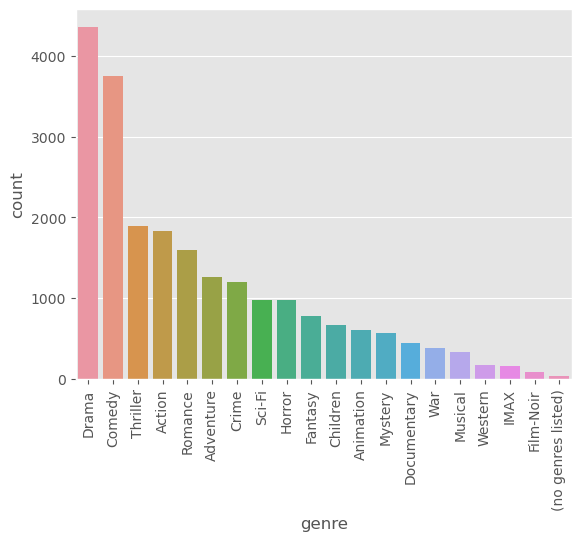

In [39]:
genre_frequency_df = pd.DataFrame([genre_frequency]).T.reset_index()
genre_frequency_df.columns = ['genre', 'count']

sns.barplot(x='genre', y='count', data=genre_frequency_df.sort_values(by='count', ascending=False))
plt.xticks(rotation=90)
plt.show()

In [40]:
# Applying one hot encoding.

genres = set(g for G in movies['genres'] for g in G)

for g in genres:
    movies[g] = movies.genres.transform(lambda x: int(g in x))
    
movie_genres = movies.drop(columns=['movieId', 'title','genres'])

In [41]:
movie_genres.head()

,Thriller,(no genres listed),War,Mystery,Horror,Action,Musical,Western,Documentary,Romance,Children,Film-Noir,Sci-Fi,Comedy,Adventure,IMAX,Animation,Fantasy,Crime,Drama
0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,1,0,0
1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


#### A cosine similarity matrix was created to compute similarity scores between movies based on genres

In [43]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(movie_genres, movie_genres)
print(f"Dimensions of our genres cosine similarity matrix: {cosine_sim.shape}")

Dimensions of our genres cosine similarity matrix: (9742, 9742)


In [44]:
from fuzzywuzzy import process

def movie_finder(title):
    all_titles = movies['title'].tolist()
    closest_match = process.extractOne(title,all_titles)
    return closest_match[0]

In [45]:
movie_idx = dict(zip(movies['title'], list(movies.index)))
#idx = movie_idx[title]
#print(f"Movie index for Jumanji: {idx}")

In [46]:
def get_content_based_recommendations(title_string, n_recommendations=10):
    title = movie_finder(title_string)
    idx = movie_idx[title]
    
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:(n_recommendations+1)]
    
    # Getting indices
    similar_movies = [i[0] for i in sim_scores]
    
    #print(f"Because you watched {title}:")
    #print(movies['title'].iloc[similar_movies])
    
    # Create DataFrame with Titles and Similarity Scores
    recommendations = pd.DataFrame({
        'Rank': range(1, n_recommendations + 1),
        'Title': movies['title'].iloc[similar_movies].values,
        #'Similarity Score': [i[1] for i in sim_scores]
    })
    
    print(f"Because you watched {title}:")
    #display(recommendations)  # Display DataFrame in Jupyter

    return recommendations

In [47]:
get_content_based_recommendations('Father of the Bride Part II', 10)

Because you watched Father of the Bride Part II (1995):


,Rank,Title
0,1,Four Rooms (1995)
1,2,Ace Ventura: When Nature Calls (1995)
2,3,Bio-Dome (1996)
3,4,Friday (1995)
4,5,Black Sheep (1996)
5,6,Mr. Wrong (1996)
6,7,Happy Gilmore (1996)
7,8,"Steal Big, Steal Little (1995)"
8,9,Flirting With Disaster (1996)
9,10,Down Periscope (1996)


In [48]:
#movie_name = input("Enter Movie Name")
print(get_content_based_recommendations(movie_name, 10))

Because you watched Dark Knight, The (2008):
   Rank                                           Title
0     1                           Need for Speed (2014)
1     2  Fast Five (Fast and the Furious 5, The) (2011)
2     3                          Dead Presidents (1995)
3     4                              Bad Company (1995)
4     5             Faster Pussycat! Kill! Kill! (1965)
5     6                        Menace II Society (1993)
6     7                          Substitute, The (1996)
7     8                          Nothing to Lose (1994)
8     9                        Untouchables, The (1987)
9    10                            Monument Ave. (1998)


In [49]:
import gradio as gr

def greet(movie_name):
    movie_df = get_content_based_recommendations(movie_name) 
    return movie_df 

# Creating the Gradio interface
demo = gr.Interface(
    fn=greet,         # Function to call
    inputs="text",    # User inputs movie name
    outputs="text",   # Output is displayed as text
)

demo.launch()

* Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


__Collaborative Filtering__ for user-based recommendations.

__Content-Based Filtering__ for genre-based recommendations.


Below are the reference I have used:

https://www.datacamp.com/courses/building-recommendation-engines-in-python

https://towardsdatascience.com/recommender-systems-a-complete-guide-to-machine-learning-models-96d3f94ea748/

https://www.geeksforgeeks.org/recommendation-system-in-python/

https://www.youtube.com/watch?v=kuC38ZCcbZI